In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")

###  Steps.

* Visualise the data.
* Decomposition.
* Select Parameters.
* Evaluate the Model.
* Make Predictions.

In [13]:
data = pd.read_csv("Electricity Consumption.csv")

In [14]:
data['DATE'] = data['DATE'].apply(lambda x: pd.to_datetime(x))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   DATE                          561 non-null    datetime64[ns]
 1   Electricty_Consumption_in_TW  561 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.9 KB


In [15]:
data.rename(columns={'DATE':'date', 'Electricty_Consumption_in_TW':'consumption'},inplace=True)

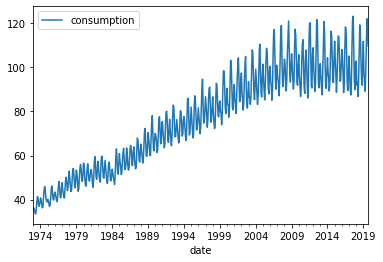

In [16]:
data.plot(kind='line', x='date',y='consumption');

In [17]:
train = data[data['date'].dt.year<2018].set_index('date')
test = data[data['date'].dt.year>2017].set_index('date')

In [18]:
data.set_index('date',inplace=True)

### Preliminary Test: Decomposition.

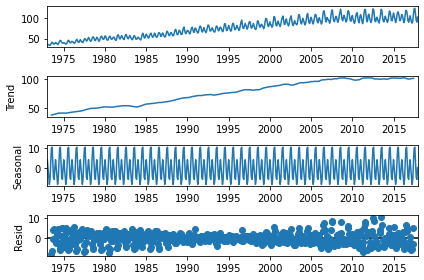

In [19]:
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train, model='additive', period = 12)
result.plot()
plt.show()
trend = result.trend
trend.dropna(inplace=True)
seasonality = result.seasonal
seasonality.dropna(inplace=True)
residual = result.resid
residual.dropna(inplace=True)

Since we can see that there is a very clear trend and seasonality, there is a high probability that SARIMA will do a better hob of forecasting this data, however we will try both ARIMA and SARIMA to make sure.

### Model 1: ARIMA.

In [20]:
from statsmodels.tsa.arima.model import ARIMA

In [21]:
def error_score(data,test_data,order):
    warnings.filterwarnings("ignore")
    temp = deepcopy(test_data)
    model = ARIMA(data, order=order)
    model_fit = model.fit()
    temp['predicted'] = model_fit.forecast(steps=len(test_data))
    temp['error'] = (temp['consumption'] - temp['predicted'])**2
    return temp.error.mean()

In [70]:
# selecting parameters for p,d and q.

def get_params(data,test_data):
    p_values = range(0,10)
    d_values = [0,1,2]
    q_values = [0,1,2,3]
    
    score, params = 1000000, None
    for p in p_values:
            for d in d_values:
                for q in q_values:
                    try:
                        order = (p,d,q)
                        mse = error_score(data,test_data,order)
                        if mse < score:
                            score, params = mse, order
                        print(order,'MSE:',mse)
                    except:
                        continue
    print('best order:',params,'MSE:',score)
                    
get_params(train,test)

(0, 0, 0) MSE: 846.984376777287
(0, 0, 1) MSE: 817.6225728656066
(0, 0, 2) MSE: 800.7963037364761
(0, 0, 3) MSE: 791.2971302182757
(0, 1, 0) MSE: 117.09165417142859
(0, 1, 1) MSE: 167.8053885919481
(0, 1, 2) MSE: 274.13802319433915
(0, 1, 3) MSE: 121.6664151203747
(0, 2, 0) MSE: 21920.904716642824
(0, 2, 1) MSE: 42161.47247348731
(0, 2, 2) MSE: 184.6131899303661
(0, 2, 3) MSE: 308.867883762656
(0, 3, 0) MSE: 3450804.944243656
(0, 3, 1) MSE: 22686.129659451322
(0, 3, 2) MSE: 43489.43002320824
(0, 3, 3) MSE: 175.8073115681846
(1, 0, 0) MSE: 252.13622083351973
(1, 0, 1) MSE: 296.7695267404892
(1, 0, 2) MSE: 419.7792897847065
(1, 0, 3) MSE: 122.22852302336031
(1, 1, 0) MSE: 183.76025840782737
(1, 1, 1) MSE: 217.4064176799609
(1, 1, 2) MSE: 122.85790887980014
(1, 1, 3) MSE: 126.37978569554477
(1, 2, 0) MSE: 44845.12151531823
(1, 2, 1) MSE: 205.8740482637098
(1, 2, 2) MSE: 244.8196586213949
(1, 2, 3) MSE: 291.8181295916596
(1, 3, 0) MSE: 3329489.43607871
(1, 3, 1) MSE: 46555.680058606056
(1,

RMSE: 2.6869880822687833


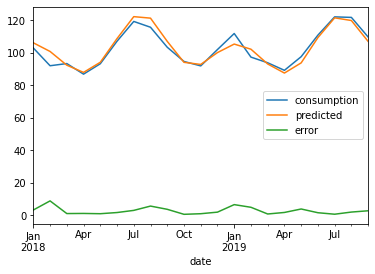

In [42]:
model = ARIMA(train, order=(8,1,3))
model_fit = model.fit()
temp = test.copy()
temp['predicted'] = model_fit.forecast(steps=21)
temp['error'] = np.sqrt((temp['consumption']-temp['predicted'])**2)
temp.plot(kind='line');
print('RMSE:',temp.error.mean())

In [23]:
arima_model = ARIMA(data, order=(8,1,3))
arima_model_fit = arima_model.fit()
predictions_arima = pd.DataFrame(arima_model_fit.forecast(steps=24))
predictions_arima

,predicted_mean
2019-10-01,99.531090
2019-11-01,98.871840
2019-12-01,105.077655
2020-01-01,108.120060
2020-02-01,103.043941
2020-03-01,94.315643
2020-04-01,90.401506
2020-05-01,97.560065
2020-06-01,111.665442
2020-07-01,121.773924


In [24]:
# saving our predictions
predictions_arima.to_csv('arima_predictions.csv')

### Model 2: SARIMA.

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def error_score(data,test_data,order,sorder,trend):
    warnings.filterwarnings("ignore")
    temp = deepcopy(test_data)
    model = SARIMAX(data, order=order,seasonal_order=sorder, trend=trend)
    model_fit = model.fit()
    temp['predicted'] = model_fit.forecast(steps=len(test_data))
    temp['error'] = (temp['consumption'] - temp['predicted'])**2
    return temp.error.mean()

def get_params(data,test_data):
    models = list()
    score, params = 1000000, None
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0,1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [1, 2]
    D_params = [1]
    Q_params = [0, 1, 2]
    m_params = [12]
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
                                    try:
                                        mse = error_score(data, test_data, cfg[0],cfg[1],cfg[2])
                                        if mse < score:
                                            score, params = mse, cfg
                                            print(cfg, 'MSE:',mse)
                                    except:
                                        continue
    print('best config:',params,'MSE:',score)
    
get_params(train,test)

[(0, 0, 0), (1, 1, 0, 12), 'n'] MSE: 11.616290478297838
[(0, 0, 0), (1, 1, 2, 12), 'n'] MSE: 11.130330381220341
[(0, 0, 0), (2, 1, 2, 12), 'n'] MSE: 10.022975032629448
[(1, 1, 1), (2, 1, 2, 12), 'n'] MSE: 10.020545168881856
[(2, 0, 2), (2, 1, 2, 12), 'n'] MSE: 9.523692602132982
best order: [(2, 0, 2), (2, 1, 2, 12), 'n'] MSE: 9.523692602132982


RMSE: 2.2711305682872243


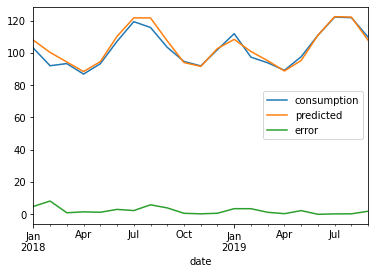

In [41]:
model = SARIMAX(train, order=(2,0,2), seasonal_order=(2,1,2,12), trend='n')
model_fit = model.fit()
temp = test.copy()
temp['predicted'] = model_fit.forecast(steps=21)
temp['error'] = np.sqrt((temp['consumption']-temp['predicted'])**2)
temp.plot(kind='line');
print('RMSE:',temp.error.mean())

In [29]:
sarimax_model = SARIMAX(data, order=(2,0,2), seasonal_order=(2,1,2,12), trend='n')
sarimax_model_fit = sarimax_model.fit()
predictions_sarima = pd.DataFrame(sarimax_model_fit.forecast(steps=24))
predictions_sarima

,predicted_mean
2019-10-01,96.902118
2019-11-01,94.733096
2019-12-01,103.255207
2020-01-01,111.256779
2020-02-01,102.044390
2020-03-01,97.278276
2020-04-01,91.046153
2020-05-01,97.282819
2020-06-01,110.862677
2020-07-01,121.997906


In [31]:
predictions_sarima.to_csv('sarima_predictions.csv')

In [34]:
predictions_arima['sarima'] = predictions_sarima['predicted_mean']
predictions_arima

,predicted_mean,sarima
2019-10-01,99.531090,96.902118
2019-11-01,98.871840,94.733096
2019-12-01,105.077655,103.255207
2020-01-01,108.120060,111.256779
2020-02-01,103.043941,102.044390
2020-03-01,94.315643,97.278276
2020-04-01,90.401506,91.046153
2020-05-01,97.560065,97.282819
2020-06-01,111.665442,110.862677
2020-07-01,121.773924,121.997906


Above, we see that while both models caught the seasonality of the data, i.e, peaks during December-january and July-August and troughs during April and November, the SARIMA model also captured the trend of the peaks increasing between the years, whereas the ARIMA model predicted a lower peak in 2021 than in 2020.

This is further testified due to the SARIMA model having a lower MSE.